# Assignment 2

**Loading the Packages**

In [1]:
import pandas as pd
from surprise import Reader
from surprise import Dataset as D1
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import NMF
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import SlopeOne
from surprise import CoClustering
from surprise import accuracy
from surprise.model_selection import train_test_split
from scipy import sparse
import numpy as np
## LightFM package
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
import pdb
from lightfm.data import Dataset

/Users/sanchit/da2020/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


### PLEASE NOTE: IT IS VERY IMPORTANT THAT YOU PLACE THIS Assignment2.ipynb file in the folder 02  to succesfully load the datasets and not give any error as was advised.

* **Loading the dataset and minor preprocessing**

In [2]:
columns=['userId', 'productId', 'ratings','timestamp']
baby_data=pd.read_csv('ratings_baby.csv',names=columns)
baby_data.drop('timestamp',axis=1,inplace=True)

In [3]:
baby_data.head()

userId   productId  ratings
0  A28O3NP6WR5517  0188399313      5.0
1   AX0M1Z6ZWO52J  0188399399      5.0
2  A1KD7N84L7NIUT  0188399518      4.0
3  A29CUDEIF4X1UO  0188399518      3.0
4  A32592TYN6C9EM  0316967297      4.0

#### The cell below gives us some summary of ratings

In [4]:
baby_data.describe()

ratings
count  915446.000000
mean        4.117695
std         1.289458
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000

#### As can be seen below we have no null value and there are in total 915446 cells

In [5]:
baby_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915446 entries, 0 to 915445
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     915446 non-null  object 
 1   productId  915446 non-null  object 
 2   ratings    915446 non-null  float64
dtypes: float64(1), object(2)
memory usage: 21.0+ MB


#### PLEASE NOTE:: Some plots of plotly don't seem to appear when opening the notebook again which might be why there is blank space instead of plots please run those particular blocks of code if you want to visualize the plots(i have provided the plots in report also).

## Exploratory Data Analysis

### Ratings Distribution 

In [7]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

As can be seen from the plot below 60 % of our users have given 5 ratings to product while a minority of products are given lower ratings such as 1 or 2.

In [8]:
data = baby_data['ratings'].value_counts().sort_index(ascending=False)

trace = go.Bar(x=data.index,
              text = ['{:.2f}%'.format(val) for val in (data.values/baby_data.shape[0]*100)],
              textposition = 'auto',
              textfont = dict(color='#000000'),
              y = data.values,)

layout = dict(title= 'Distribution of Product ratings',
              xaxis= dict(title='Rating'),
              yaxis= dict(title= 'Count'))

fig = go.Figure(data=[trace], layout= layout)
iplot(fig)

The plot below shows us distribution of number of ratings per baby product. While the table shows us that most of the products are not rated by users and product with product id **B000IDSLOG** is the most rated product with **3648** ratings.

In [9]:
data = baby_data.groupby('productId')['ratings'].count().clip(upper=50)

trace = go.Histogram(x= data.values,
                    name='Ratings',
                    xbins=dict(start=0,end=50,size=2))

layout = go.Layout(title='Distribution of Number of Ratings per Baby Product',
                  xaxis= dict(title='No. of Ratings per Baby Product'),
                  yaxis= dict(title='Count'),
                  bargap=0.2)
fig = go.Figure(data=[trace], layout= layout)
iplot(fig)

In [10]:
vCount = baby_data.groupby('productId')['ratings'].count().reset_index().sort_values('ratings',ascending=False)

In [12]:
vCount[:10]

productId  ratings
5641   B000IDSLOG     3648
2996   B000BNQC58     2923
18267  B00295MQLU     2832
35870  B0052QYLUM     2830
9873   B000YDDF6O     2682
1025   B0000DEW8N     2458
6687   B000LXQVA4     2211
10534  B0011URFRE     2185
618    B0000635WI     2085
15919  B001OC5UMQ     1928

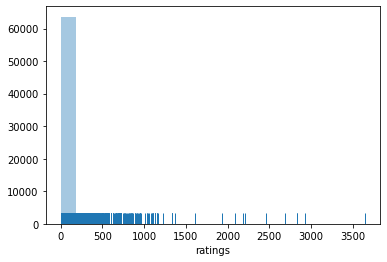

In [13]:
import seaborn as sns
sns.distplot(vCount["ratings"],bins=20,kde=False, rug=True)

### Rating Distribution by Users

Figure 4 and 5 tells us that most of the users don’t give rating to the product and user with user id **ARIFCL50JD5SK** has rated **155** products the most among any user

In [14]:
data = baby_data.groupby('userId')['ratings'].count().clip(upper=50)

trace = go.Histogram(x= data.values,
                    name='Ratings',
                    xbins=dict(start=0,end=50,size=2))

layout = go.Layout(title='Distribution of Number of Ratings Per User',
                  xaxis= dict(title='Ratings per User'),
                  yaxis= dict(title='Count'),
                  bargap=0.2)
fig = go.Figure(data=[trace], layout= layout)
iplot(fig)

In [13]:
vCount = baby_data.groupby('userId')['ratings'].count().reset_index().sort_values('ratings',ascending=False)
print(vCount[:10])

                userId  ratings
498578   ARIFCL50JD5SK      155
466858   AJGU56YG8G1DQ      140
450551   AF8SREA2XE7BJ      122
466373   AJC88791BZEW7      105
169306  A276OI0NHBYORX       95
241126  A2PNW6QDW8OPY0       93
86966   A1M5ZT35YX6TIN       82
486301   AOEUN9718KVRD       81
526651   AYNNJ0DBGL5H7       81
562     A100L918633LUO       81


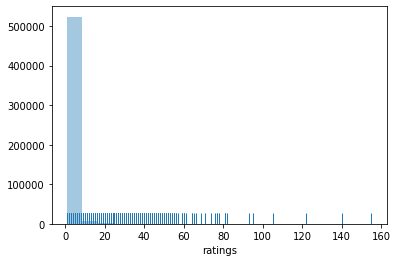

In [14]:
sns.distplot(vCount["ratings"],bins=20,kde=False, rug=True)

As can be concluded from the plots above not a lot of products get rated by users and also not alot of users give rating to product so using these users and products won't help our model much from learning.Moreover considering the size of the dataset and my CPU/RAM limitations i decided to trim my dataset as can be seen below

In [15]:
min_product_ratings=2
filter_product = baby_data['productId'].value_counts() > min_product_ratings
filter_product = filter_product[filter_product].index.tolist()

min_user_ratings=2
filter_users = baby_data['userId'].value_counts() >min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = baby_data[(baby_data['productId'].isin(filter_product)) & (baby_data['userId'].isin(filter_users))]
print('Original df shape: {}'.format(baby_data.shape))
print('Modified df shape: {}'.format(df_new.shape))

Original df shape: (915446, 3)
Modified df shape: (363430, 3)


Doing this reduces my dataset from 915446 to 363430 cells as can be seem above

### Pure Collaborative Model trained using Surprise Package

Loading our dataset using Reader and load from df function for easy training on surprise packages function

In [16]:
reader = Reader(rating_scale=(1,5))
data = D1.load_from_df(df_new[['userId', 'productId', 'ratings']], reader)

In [17]:
benchmark = []
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor()]:
    print(algorithm)
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    tmp= pd.DataFrame.from_dict(results).mean(axis=0)
    tmp= tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)

I decided to not train the model on KNN as it was taking a lot of time to train and my system was getting overheated which is the reason why the below code is commented

In [18]:
#for algorithm in [KNNBaseline(),KNNBasic(), KNNWithMeans(),KNNWithZScore(),BaselineOnly(), CoClustering()]:
#    print(algorithm)
#    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
#    tmp= pd.DataFrame.from_dict(results).mean(axis=0)
#    tmp= tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
#    benchmark.append(tmp)

#### Visualisation of our results of collaborative model

AS can be seen from table below SVD achieves the best result on test aset and also doesn't take as much time as other models

In [19]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

test_rmse   fit_time  test_time
Algorithm                                       
SVD               1.117885  14.733165   0.937826
SVDpp             1.119739  37.335460   2.431954
SlopeOne          1.361529  20.788841   1.730172
NMF               1.379070  22.311824   0.913248
NormalPredictor   1.523911   0.446362   0.968681

In [20]:
algo = SVD()
print('Using ALS')
cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)

Using ALS


{'test_rmse': array([1.10987451, 1.12153509, 1.10931332, 1.11263643, 1.11166554]),
 'fit_time': (17.085803031921387,
  18.384449005126953,
  17.899696826934814,
  17.91861605644226,
  18.247694969177246),
 'test_time': (0.5667500495910645,
  0.8525800704956055,
  0.6058011054992676,
  0.5502650737762451,
  0.8449211120605469)}

In [21]:
trainset,testset= train_test_split(data,test_size=0.25)
algo = SVD()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 1.1169


1.1169146135080499

Sample of some of the predictions made by our model

In [22]:
predictions[:10]

[Prediction(uid='A5ALC1O6SNB32', iid='B008K42MAE', r_ui=2.0, est=4.332846895153385, details={'was_impossible': False}),
 Prediction(uid='A34DFIKS1RBD4J', iid='B00BQYVNFU', r_ui=5.0, est=4.342303782237953, details={'was_impossible': False}),
 Prediction(uid='A3UVR0TG2URSHD', iid='B0009RNXNK', r_ui=2.0, est=4.108934718817059, details={'was_impossible': False}),
 Prediction(uid='A1K3VKI80SLK2C', iid='B000UUBRYI', r_ui=5.0, est=4.498952120026894, details={'was_impossible': False}),
 Prediction(uid='A1LWOA6WIP1CFX', iid='B002FB7FLE', r_ui=5.0, est=4.499778920834323, details={'was_impossible': False}),
 Prediction(uid='ALFZ2X9X9HJ1P', iid='B000A88JYQ', r_ui=3.0, est=4.503379864588844, details={'was_impossible': False}),
 Prediction(uid='A2TNBJ0AS98AJR', iid='B002B43NE8', r_ui=5.0, est=4.145654046294948, details={'was_impossible': False}),
 Prediction(uid='A1BKNK0ZYHZZIE', iid='B001CWB3KG', r_ui=5.0, est=4.889577438154851, details={'was_impossible': False}),
 Prediction(uid='A10ERGWIRWBOHX', 

#### Below code is taken from the tutorial on Recommendor System provided by the TA's

In [23]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:
        return 0

def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid','iid','rui','est','details'])
df['Iu']= df.uid.apply(get_Iu)
df['Ui']= df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [24]:
df.head()

uid         iid  rui       est                    details  Iu  \
0   A5ALC1O6SNB32  B008K42MAE  2.0  4.332847  {'was_impossible': False}   2   
1  A34DFIKS1RBD4J  B00BQYVNFU  5.0  4.342304  {'was_impossible': False}  10   
2  A3UVR0TG2URSHD  B0009RNXNK  2.0  4.108935  {'was_impossible': False}   2   
3  A1K3VKI80SLK2C  B000UUBRYI  5.0  4.498952  {'was_impossible': False}   3   
4  A1LWOA6WIP1CFX  B002FB7FLE  5.0  4.499779  {'was_impossible': False}  10   

    Ui       err  
0    2  2.332847  
1   23  0.657696  
2   35  2.108935  
3   79  0.501048  
4  128  0.500221

Below code will generate the best and the worst predictions

In [25]:
best=df.sort_values(by='err')[:20]
worst=df.sort_values(by='err')[-10:]

In [26]:
best

uid         iid  rui  est                    details  Iu  \
44638  A3J1SCBBYKBJP1  B002EEO68C  5.0  5.0  {'was_impossible': False}   5   
52946  A1BLC62SBF3PNQ  B0000DEW8N  5.0  5.0  {'was_impossible': False}   4   
13386  A2OA0WU1HPMT6Q  B0012AII9M  5.0  5.0  {'was_impossible': False}   6   
811    A100L918633LUO  B004X0WBHS  5.0  5.0  {'was_impossible': False}  62   
515     AFP43ZIYYKFWZ  B00081J3N6  5.0  5.0  {'was_impossible': False}  12   
5450   A2NCKITN4FQY3X  B004GJXMA6  5.0  5.0  {'was_impossible': False}   4   
52948  A1O7T0PYJ5N6ZO  B00494DNZC  5.0  5.0  {'was_impossible': False}   6   
60397   A914TQVHI872U  B000GJIE4E  5.0  5.0  {'was_impossible': False}  19   
40209  A2KI9QFHCMOU69  B0042RU2UU  5.0  5.0  {'was_impossible': False}  17   
60427   AX687FIGSJFFJ  B0033ZN19Q  5.0  5.0  {'was_impossible': False}  22   
36969  A2QXKGUF94JLPZ  B00208NUOI  5.0  5.0  {'was_impossible': False}   2   
80782  A1RM4XQS6M0TA5  B00208KJ0G  5.0  5.0  {'was_impossible': False}   6   
44661   AEVVHSAW044FB  B004W93MFK  5.0  5.0  {'was_impossible': False}  10   
72921  A3UJJ6HH70Q71Y  B000069EXN  5.0  5.0  {'was_impossible': False}  22   
25262  A3EGZ6NHMB6QWN  B003HIXOTQ  5.0  5.0  {'was_impossible': False}  23   
5365   A2VEWJCITH5ZAB  B00501YN20  5.0  5.0  {'was_impossible': False}   7   
527     AJGU56YG8G1DQ  B000O1VMXE  5.0  5.0  {'was_impossible': False}  94   
77208  A3VQJHS8C2QASE  B002ZMB3Y8  5.0  5.0  {'was_impossible': False}   6   
32213  A2CCE9AQBTCKCE  B00BUO4664  5.0  5.0  {'was_impossible': False}  10   
40998  A2NH7VZMGLRL7Y  B004044LD4  5.0  5.0  {'was_impossible': False}  11   

        Ui  err  
44638   52  0.0  
52946  722  0.0  
13386  371  0.0  
811    142  0.0  
515    198  0.0  
5450   105  0.0  
52948   63  0.0  
60397  397  0.0  
40209   18  0.0  
60427   24  0.0  
36969   56  0.0  
80782   38  0.0  
44661  262  0.0  
72921  200  0.0  
25262   83  0.0  
5365    48  0.0  
527     14  0.0  
77208   25  0.0  
32213   29  0.0  
40998  333  0.0

In [27]:
worst

uid         iid  rui       est                    details  \
67483  A12GLX4MDSSHI7  B0000DEW8N  1.0  4.954720  {'was_impossible': False}   
9998   A2FE72V4ONUY2R  B004BU3CDW  1.0  4.962312  {'was_impossible': False}   
72341   A43A6RSVSGV04  B0000635WI  1.0  4.978291  {'was_impossible': False}   
77721  A1VQSFKF00KOQ3  B00081J3MW  1.0  4.988547  {'was_impossible': False}   
83141  A2MYKIDT6XN44E  B004OYWY98  1.0  5.000000  {'was_impossible': False}   
42634  A3U5HGU782L8IV  B004DFO57M  1.0  5.000000  {'was_impossible': False}   
82104  A27ABRTMWPE2KZ  B004DFO57M  1.0  5.000000  {'was_impossible': False}   
67167   AATZSBPZI9G1K  B004OR1E1E  1.0  5.000000  {'was_impossible': False}   
33274  A3T5P12Q2AOMDX  B002VHBU2W  1.0  5.000000  {'was_impossible': False}   
24852  A2UIWU65I1DLHI  B004DFO57M  1.0  5.000000  {'was_impossible': False}   

       Iu   Ui       err  
67483   4  722  3.954720  
9998    3   39  3.962312  
72341   6  397  3.978291  
77721   2   26  3.988547  
83141   7   13  4.000000  
42634   3  221  4.000000  
82104   8  221  4.000000  
67167  10   52  4.000000  
33274   9  288  4.000000  
24852   7  221  4.000000

The reason why the product **B004DFO57M** got such rating is that that majority of the user rated it 5 while in the test case user gave it a rating of 1 which was an outlier which can be confirmed using the distribution plot made below and also the table below.

In [28]:
df_new.loc[df_new['productId']=='B0006HBS1M']['ratings'].describe()

count    348.000000
mean       4.114943
std        1.274220
min        1.000000
25%        3.750000
50%        5.000000
75%        5.000000
max        5.000000
Name: ratings, dtype: float64

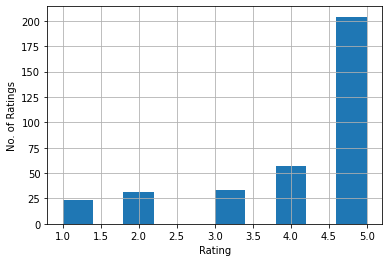

In [29]:
import matplotlib.pyplot as plt
# %matplotlib notebook

df_new.loc[df_new['productId']=='B0006HBS1M']['ratings'].hist()
plt.xlabel('Rating')
plt.ylabel('No. of Ratings')
plt.show()

Rating of 1 was an outlier while majority of the users gave this product a rating of 5.

### Hybrid Model trained using LightFM Package

Loading our dataset using Dataset function and using te=he fit function for loading our Items and Users so as to make interaction matrix later using the build function

In [30]:

dataset = Dataset()
dataset.fit(df_new['userId'].unique(),
            df_new['productId'].unique())
# old way of making sparse matrix lightfm has in built features so using that
#mat = sparse.coo_matrix((df_new["ratings"], (df_new["userId"],  df_new["productId"])))

As can be seen below we have 71735 unique users and 27444 unique Products

In [31]:
num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))

Num users: 71735, num_items 27444.


In [32]:
#interactions = dataset.build_interactions((df_new['userId'].values, df_new['productId'].values))
(interactions,weights) = dataset.build_interactions(df_new.values)

print(repr(interactions))
print(repr(weights))

<71735x27444 sparse matrix of type '<class 'numpy.int32'>'
	with 363430 stored elements in COOrdinate format>
<71735x27444 sparse matrix of type '<class 'numpy.float32'>'
	with 363430 stored elements in COOrdinate format>


### Convert to train and test set.

In [34]:

from lightfm.cross_validation import random_train_test_split
(train, test) = random_train_test_split(interactions,test_percentage=.2,random_state=np.random.RandomState(3))
(train_wt, test_wt) = random_train_test_split(weights,test_percentage=.2,random_state=np.random.RandomState(3))


 i trained the Hybrid model using the LightFM package. The metadata json file of the dataset has data about every products such as : 

1.) ProductID 

2.)Product Name

3.) Brand Name

4.) Description of the product 

5.) Related Product.

The brand name basically tells about the name of the company/brand which makes the product.

The related product metric tells us about what other product were viewed or bought after buying this product. It has multiple other subcategories in it such as 

1.) Items viewed after buying this product 

2.) Items bought after buying this product 
3.) Items bought together

I trained three Hybrid model using two different loss function WARP and BPR(so in total 6).

**Pure Collaborative model trained on LightFM**

In [35]:
model = LightFM(learning_rate=0.1, loss='warp',no_components=30)
model.fit(train, sample_weight = train_wt,epochs=50)

train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

# print('Precision: train %.2f, test %.2f.' % (trabin_precision, test_precision))
# print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

In [36]:
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.14, test 0.00.
AUC: train 1.00, test 0.75.


In [40]:
model = LightFM(learning_rate=0.1, loss='bpr')
model.fit(train, sample_weight = train_wt,epochs=50)

In [41]:
train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()

In [42]:
train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

In [43]:
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.05, test 0.00.
AUC: train 0.97, test 0.54.


### Hybrid Model using Item Features of Products

#### Using Brands as an Item Feature and creating a Hybrid(Collaborative-Content Based Recommendor Model)

In [114]:
columns=['productId', 'brand']
vfeat=pd.read_csv('brand.csv',names=columns)
vfeat = vfeat.iloc[1:]
vfeat.head()

productId        brand
1  0188399313  Lifefactory
2  0188399518  Planet Wise
3  0615447279          NaN
4  097293751X     Time Too
5  0974671517  Wee Gallery

In [115]:
df2 = pd.merge(df_new,vfeat,on='productId')

In [116]:
df2.head()

userId   productId  ratings     brand
0   ATTTLHRK3VOOL  0615447279      2.0       NaN
1  A3BRNASAP5PDFZ  0615447279      5.0       NaN
2  A1HK2FQW6KXQB2  097293751X      5.0  Time Too
3  A19K65VY14D13R  097293751X      5.0  Time Too
4  A3504A8DLDCQ3J  097293751X      5.0  Time Too

In [117]:
df2 = df2.dropna()

In [ ]:
#print(vfeat['productId'])
#print(vfeat['brand'])
#print(df_new['productId'].values)

In [49]:
df2.head()

userId   productId  ratings     brand
2  A1HK2FQW6KXQB2  097293751X      5.0  Time Too
3  A19K65VY14D13R  097293751X      5.0  Time Too
4  A3504A8DLDCQ3J  097293751X      5.0  Time Too
5  A2LL1TGG90977E  097293751X      5.0  Time Too
6   A5G19RYX8599E  097293751X      5.0  Time Too

In [50]:
dataset = Dataset()
dataset.fit(iter(df2['userId'].unique()),
            iter(df2['productId'].unique()),
            item_features = iter(df2['brand'].unique()))

In [51]:
df2.head()

userId   productId  ratings     brand
2  A1HK2FQW6KXQB2  097293751X      5.0  Time Too
3  A19K65VY14D13R  097293751X      5.0  Time Too
4  A3504A8DLDCQ3J  097293751X      5.0  Time Too
5  A2LL1TGG90977E  097293751X      5.0  Time Too
6   A5G19RYX8599E  097293751X      5.0  Time Too

In [52]:
(interactions,weights) = dataset.build_interactions((x[0],x[1],x[2]) for x in df2.values)

print(repr(interactions))
print(repr(weights))

<69139x13340 sparse matrix of type '<class 'numpy.int32'>'
	with 263637 stored elements in COOrdinate format>
<69139x13340 sparse matrix of type '<class 'numpy.float32'>'
	with 263637 stored elements in COOrdinate format>


In [53]:
print(dataset.interactions_shape())
dataset.item_features_shape()

(69139, 13340)


(13340, 15081)

In [54]:
item_features = dataset.build_item_features(((i[1],[i[3]]) for i in df2.values))

In [55]:
from lightfm.cross_validation import random_train_test_split
(train, test) = random_train_test_split(interactions,test_percentage=.2,random_state=np.random.RandomState(3))
(train_wt, test_wt) = random_train_test_split(weights,test_percentage=.2,random_state=np.random.RandomState(3))

In [56]:
model = LightFM(learning_rate=0.1, loss='warp',no_components=30)
model.fit(interactions, sample_weight = weights,item_features = item_features,epochs=10)

In [57]:
train_precision = precision_at_k(model, train, item_features=item_features,k=10).mean()
test_precision = precision_at_k(model, test,item_features=item_features, k=10).mean()
train_auc = auc_score(model, train,item_features=item_features).mean()
test_auc = auc_score(model, test,item_features=item_features).mean()

In [58]:
train_auc = auc_score(model, train,item_features=item_features).mean()
test_auc = auc_score(model, test,item_features=item_features).mean()

**Precision and AUC values of Hybrid Model with brand as an Item Feature trained using WARP loss function as can be seen from the results below we have a better result than Pure Collaborative model**

In [59]:
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.06, test 0.03.
AUC: train 0.99, test 0.99.


In [60]:
model = LightFM(learning_rate=0.1, loss='bpr',no_components=30)
model.fit(interactions, sample_weight = weights,item_features = item_features,epochs=10)

In [61]:
train_precision = precision_at_k(model, train, item_features=item_features,k=10).mean()
test_precision = precision_at_k(model, test,item_features=item_features, k=10).mean()
train_auc = auc_score(model, train,item_features=item_features).mean()
test_auc = auc_score(model, test,item_features=item_features).mean()

**Precision and AUC values of Hybrid Model with brand as an Item Feature trained using BPR loss function as can be seen from the results below we have a better result than Pure Collaborative model but not as good as the results obtained on the WARP loss function**

In [62]:
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.05, test 0.03.
AUC: train 0.98, test 0.97.


### Using Related Metric(Products Bought,Viewed, Bought-together) as an item feature and creating a Hybrid Model 

In [83]:
columns=['productId', 'related']
vfeat=pd.read_csv('short2.csv',names=columns)
vfeat = vfeat.iloc[1:]
print(vfeat.head())

    productId     related
1  097293751X  B002QYW8LW
2  097293751X  B009M63NVG
3  097293751X  B0018JWAF0
4  097293751X  B004AHMCKA
5  097293751X  B004A9ZF3Y


In [85]:
dataset = Dataset()
dataset.fit(iter(df_new['userId'].unique()),
            iter(df_new['productId'].unique()),
            item_features = iter(vfeat['related'].unique()))
           #            item_features = [tuple(i) for i in vfeat2.drop(['productId'], axis=1).values])
#            vfeat2['brand'])


In [86]:
(interactions,weights) = dataset.build_interactions((x[0],x[1],x[2]) for x in df_new.values)

print(repr(interactions))
print(repr(weights))

<71735x27444 sparse matrix of type '<class 'numpy.int32'>'
	with 363430 stored elements in COOrdinate format>
<71735x27444 sparse matrix of type '<class 'numpy.float32'>'
	with 363430 stored elements in COOrdinate format>


In [87]:
dataset.item_features_shape()

(27444, 27444)

In [88]:
item_features = dataset.build_item_features(((i[0],[i[1]]) for i in vfeat.values))

In [89]:
from lightfm.cross_validation import random_train_test_split
(train, test) = random_train_test_split(interactions,test_percentage=.2,random_state=np.random.RandomState(3))
(train_wt, test_wt) = random_train_test_split(weights,test_percentage=.2,random_state=np.random.RandomState(3))

In [90]:
model = LightFM(learning_rate=0.1, loss='warp')
model.fit(interactions, sample_weight = weights,item_features = item_features,epochs=10)

In [91]:
train_precision = precision_at_k(model, train, item_features=item_features,k=10).mean()
test_precision = precision_at_k(model, test,item_features=item_features, k=10).mean()
train_auc = auc_score(model, train,item_features=item_features).mean()
test_auc = auc_score(model, test,item_features=item_features).mean()

**Precision and AUC values of Hybrid Model with related metric as an Item Feature trained using WARP loss function we get better than Pure Collaborative model but not as good as the results obtained on the Brand as a iterm feature**

In [111]:
print('Precision: train %.4f, test %.4f.' % (train_precision, test_precision))
print('AUC: train %.4f, test %.4f.' % (train_auc, test_auc))

Precision: train 0.0197, test 0.0079.
AUC: train 0.9515, test 0.9487.


In [77]:
model = LightFM(learning_rate=0.1, loss='bpr')
model.fit(interactions, sample_weight = weights,item_features = item_features,epochs=10)

In [78]:
train_precision2 = precision_at_k(model, train, item_features=item_features,k=10).mean()
test_precision2 = precision_at_k(model, test,item_features=item_features, k=10).mean()
train_auc2 = auc_score(model, train,item_features=item_features).mean()
test_auc2 = auc_score(model, test,item_features=item_features).mean()

**Precision and AUC values of Hybrid Model with related metric as an Item Feature trained using BPR loss function we get better than Pure Collaborative model but not as good as the results obtained on the Brand as a item feature**

In [82]:
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.02, test 0.01.
AUC: train 0.95, test 0.95.


In [124]:
df2['brand'].unique()

array(['Time Too', 'SoftPlay', 'Christian Art Gifts', ...,
       'Ftbstyle Baby', 'Naugthy Baby', 'My Baby Essentials'],
      dtype=object)

### Conclusion

In Conclusion with the result that we have got i believe that if we want to use a Pure Collaborative model than we should use the one trained on **SVD** algorithm as it had the lowest RMSE value, on the other hand Hybrid model have performed better and if we want to use that we should use **Brands** as the feature for it to be trained on as it had really good AUC value and decent precision.

Although the precision value is really low for such high AUC attained in test case but in reality we are computing
top 10 precision against >27000 products so the results are still reasonable. I also believe that we could have gotten much better result by using combination of Brand and the related metric as an item feature and by tuning the hyperparameters but i wasn’t able to do it because of RAM and CPU constraints on my laptop

### Additional Code

Below is the code if you want to generate the short2.csv and brand.csv file. I provided the CSV file as it took alot of time to generate these csv files(especially the short2.csv)

##### Code to uncomment and run if you want to generate the brand.csv file

In [126]:
# import pandas as pd
# import json
# import numpy as np
# import os
# import pdb
# import ast
# vFile = "meta_Baby.json"
# #vData = json.load(open(vFile,'r'))

# dick = {}

# line_count = len(open(vFile).readlines())
# vcount = 0
# vfrom= np.empty(0)
# vto = np.empty(0)
# vfrom= []
# vto = []
# vrating = []
# with open(vFile,'r') as vdat:    
# #    for line in tqdm(vdat,total=line_count):
#     for line in vdat:
#         vcount+=1
#         if vcount%200==0:
#             print(vcount)
#         vdic = ast.literal_eval(line)
#         vbrand = vdic.get('brand')
#         if vbrand is None:
#             pdb.set_trace()
#             print(vdic)
#         if vbrand is not None:
#             vfrom.append(vdic.get('asin'))
#             vto.append(vbrand)
#             vrating.append(np.array(1))
# #print(vfrom.shape)
# #print(vto.shape)
# vfrom = np.array(vfrom)
# #vfrom = np.concatenate(vfrom,0)
# vto = np.array(vto)
# vrating = np.array(vrating)
# #vto = np.concatenate(vto,0)
# df = pd.DataFrame({"productId" : vfrom, "brand" : vto,"rating" : vrating})
# df.to_csv("brand2.csv", index=False)
# pdb.set_trace()


##### Code to uncomment and run if you want to generate the short2.csv file

In [125]:
# import pandas as pd
# import json
# import numpy as np
# import os
# import pdb
# import ast
# import tqdm
# vFile = "meta_Baby.json"
# #vData = json.load(open(vFile,'r'))

# dick = {}

# line_count = len(open(vFile).readlines())
# vcount = 0
# vfrom= np.empty(0)
# vto = np.empty(0)
# vfrom= []
# vto = []
# vcount2=0
# columns=['userId', 'productId', 'ratings']
# baby_data=pd.read_csv('baby_short.csv',names=columns)
# baby_data = baby_data.iloc[1:]
# vProduct = baby_data['productId'].unique()
# with open(vFile,'r') as vdat:    
#     for line in vdat:
#         vcount+=1
#         vdic = ast.literal_eval(line)
#         if vdic['asin'] in vProduct:
#             vdic2 = vdic.get('related')
#             vlis = []
#             if vdic2 is not None:
# #                pdb.set_trace()
#                 vkey = ['also_bought', 'bought_together', 'buy_after_viewing']
#                 for keys in vkey:
#                     val = vdic2.get(keys)
#                     if val is not None:
#                         vlis.append(val)
#                 flat_lis = [item for sublist in vlis for item in sublist if item in vProduct]
#                 flat_lis = np.array(list(set(flat_lis)))
#                 flat_lis = np.array(flat_lis)
#                 vfr = np.resize(vdic['asin'],flat_lis.shape)
#                 if vfr.shape != flat_lis.shape:
#                     pdb.set_trace()
#                 vfrom.append(vfr)
#                 vto.append(flat_lis)
#         if vcount%1000==0:
#             print(vcount)
# #pdb.set_trace()
# #print(vfrom.shape)
# #print(vto.shape)
# pdb.set_trace()
# vfrom = np.array(vfrom)
# vfrom = np.concatenate(vfrom,0)
# vto = np.array(vto)
# vto = np.concatenate(vto,0)
# df = pd.DataFrame({"productId" : vfrom, "related" : vto})
# df.to_csv("short2.csv", index=False)
# pdb.set_trace()
